In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings

from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from shap import TreeExplainer

In [145]:
import sklearn

In [147]:
python.__version__

NameError: name 'python' is not defined

In [2]:
from src.helpers import find_columns_type, find_na_columns, distribution

In [120]:
warnings.filterwarnings('ignore')

In [121]:
train_df = pd.read_csv('./data/df_train.csv')
test_df = pd.read_csv('./data/df_test.csv')
train_df.shape, test_df.shape

((276205, 26), (77837, 27))

In [122]:
train_df.sample(3)

,Unnamed: 0,order_id,departure_country,departure_city,departure_region,arrival_country,arrival_city,arrival_region,order_date,stock_departure_date,...,item_package_type,client_is_app,order_tracking_available,brand_name,item_id,item_category,delivery_service_name,type_prepayment,item_price,item_losses
106245,106245,e6d82e9c-ae38-433f-9689-cfca46b70c8a,12,41.0,1447,12,125.0,824,2017-04-29 12:24:00,20-12-00 2017-06-20,...,c82a2ea6-cbf1-46af-98c5-acd43b174f5d,True,0,[],ffc23d76-f03a-42c8-ab9d-04283436804a,25f9f297-40a8-45d9-bb67-4b0f6dad1315,5c8a6701-853f-4721-86f0-86e79f7220c4,2,734.651392,0.000000
208852,208852,25779f87-cc86-4cac-83a2-c4a5ceb7cce0,12,121.0,1405,14,541.0,839,2017-06-19 23:11:28,22-20-00 2017-06-24,...,43c32a76-e5a3-4874-85c3-5377fa50b515,True,1,"['507d2a03-9104-40ef-8c8e-dd0dd31245cc', 'f970...",0134bf91-15c0-4b1e-9ae7-f56eb437e5ad,25f9f297-40a8-45d9-bb67-4b0f6dad1315,3f1e3d6a-a194-4cf9-9026-bb03a8f544c2,2,1632.087691,0.000000
104719,104719,9501a0d8-1ff3-4359-b0c4-1dc67fe30973,12,499.0,1743,12,98.0,1090,2017-09-18 20:18:41,22-34-00 2017-10-07,...,c82a2ea6-cbf1-46af-98c5-acd43b174f5d,True,0,[],d54810ff-a8d6-4e79-9b30-628b1798c8da,25f9f297-40a8-45d9-bb67-4b0f6dad1315,5c8a6701-853f-4721-86f0-86e79f7220c4,2,975.030039,104.559179


In [123]:
test_df.sample(3)

,departure_country,departure_city,departure_region,arrival_country,arrival_city,arrival_region,item_type,client_device_type,client_browser,item_package_type,...,item_price,order_hour,order_arrival_diff,order_stock_diff,stock_delivery_service_diff,delivery_service_arrival_diff,order_day,stock_departure_day,delivery_service_departure_day,client_arrival_day
32328,12,121.0,355,12,355.0,108,0,2,1,c82a2ea6-cbf1-46af-98c5-acd43b174f5d,...,149.075263,21,7,7,0,0,Sunday,Sunday,Sunday,Sunday
5359,12,507.0,263,12,121.0,351,0,0,0,c82a2ea6-cbf1-46af-98c5-acd43b174f5d,...,408.894128,13,29,28,0,1,Sunday,Sunday,Sunday,Monday
35361,12,121.0,1732,12,125.0,824,0,0,0,c82a2ea6-cbf1-46af-98c5-acd43b174f5d,...,1890.760103,4,15,14,0,1,Tuesday,Tuesday,Tuesday,Wednesday


In [124]:
train_df.drop(train_df.columns[0], axis=1, inplace=True)
test_df.drop(test_df.columns[0], axis=1, inplace=True)

### Find Features Types

In [125]:
train_df.dtypes.unique()

array([dtype('O'), dtype('int64'), dtype('float64'), dtype('bool')],
      dtype=object)

In [126]:
train_numerical_columns, train_categorical_columns, train_bool_columns, train_other_types_columns = find_columns_type(train_df)
test_numerical_columns, test_categorical_columns, test_bool_columns, test_other_types_columns = find_columns_type(test_df)

In [127]:
len(train_other_types_columns), len(test_other_types_columns)

(0, 0)

In [128]:
train_numerical_columns == test_numerical_columns, train_categorical_columns == test_categorical_columns, train_bool_columns == test_bool_columns

(False, False, False)

In [129]:
unique_in_train = set(train_numerical_columns) - set(test_numerical_columns)
unique_in_test = set(test_numerical_columns) - set(train_numerical_columns)
unique_in_train, unique_in_test

({'departure_country', 'item_losses'},
 {'client_is_app',
  'delivery_service_arrival_diff',
  'order_arrival_diff',
  'order_hour',
  'order_stock_diff',
  'stock_delivery_service_diff'})

In [130]:
len(train_numerical_columns), len(train_categorical_columns), len(train_bool_columns)

(13, 11, 1)

In [131]:
train_df[train_bool_columns] = train_df[train_bool_columns].astype('int')
test_df[train_bool_columns] = test_df[train_bool_columns].astype('int')

In [132]:
train_numerical_columns, train_categorical_columns, train_bool_columns, train_other_types_columns = find_columns_type(train_df)
test_numerical_columns, test_categorical_columns, test_bool_columns, test_other_types_columns = find_columns_type(test_df)

In [133]:
len(train_numerical_columns), len(train_categorical_columns), len(train_bool_columns)

(14, 11, 0)

In [135]:
np.save('./data/vars/all_numerical_columns.npy', train_numerical_columns)

### Find NAN

In [16]:
train_na_columns = find_na_columns(train_df)
test_na_columns = find_na_columns(test_df)
train_na_columns, test_na_columns

({'departure_city': 6320, 'arrival_city': 8863, 'client_keywords': 214992},
 {'departure_city': 1747, 'arrival_city': 2419, 'client_keywords': 63118})

In [17]:
[i / train_df.shape[0] for i in list(train_na_columns.values())]

[0.022881555366485038, 0.032088485002081786, 0.7783783783783784]

In [18]:
[i / test_df.shape[0] for i in list(test_na_columns.values())]

[0.022444338810591363, 0.031077765073165717, 0.8108997006565001]

### Set columns for drop

In [19]:
columns_for_drop = []

In [20]:
columns_for_drop.append('client_keywords')
columns_for_drop.append('order_id')
columns_for_drop.append('item_losses')

### Check distribution for numerical features

In [21]:
train_df[train_numerical_columns].describe()

,departure_country,departure_city,departure_region,arrival_country,arrival_city,arrival_region,item_type,client_device_type,client_browser,client_is_app,order_tracking_available,type_prepayment,item_price,item_losses
count,276205.000000,269885.000000,276205.000000,276205.000000,267342.000000,276205.000000,276205.000000,276205.000000,276205.000000,276205.000000,276205.000000,276205.000000,276205.000000,276205.000000
mean,11.829728,232.526139,934.976499,11.753010,252.725737,937.165033,0.099861,3.776108,1.471617,0.964208,0.036368,1.761007,635.585094,23.584252
std,1.206116,175.040157,523.889072,1.591248,183.106162,521.315965,0.358597,32.975989,1.817060,0.185772,0.187204,0.575160,565.005843,47.763472
min,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-480.848430
25%,12.000000,121.000000,452.000000,12.000000,121.000000,496.000000,0.000000,1.000000,0.000000,1.000000,0.000000,2.000000,261.426184,0.000000
50%,12.000000,125.000000,856.000000,12.000000,125.000000,856.000000,0.000000,2.000000,1.000000,1.000000,0.000000,2.000000,489.399183,0.000000
75%,12.000000,352.000000,1405.000000,12.000000,386.000000,1405.000000,0.000000,2.000000,2.000000,1.000000,0.000000,2.000000,827.864100,34.209188
max,13.000000,714.000000,1755.000000,14.000000,714.000000,1755.000000,2.000000,1152.000000,9.000000,1.000000,1.000000,3.000000,13787.240979,1234.954697


In [22]:
test_df[test_numerical_columns].describe()

,departure_country,departure_city,departure_region,arrival_country,arrival_city,arrival_region,item_type,client_device_type,client_browser,client_is_app,order_tracking_available,type_prepayment,item_price
count,77837.000000,76090.000000,77837.000000,77837.000000,75418.000000,77837.000000,77837.000000,77837.000000,77837.000000,77837.000000,77837.000000,77837.000000,77837.000000
mean,11.856534,235.254068,908.080527,11.787967,256.902742,907.935442,0.130336,6.853707,1.580392,0.956165,0.024898,0.606293,651.817828
std,1.106796,175.389198,517.183543,1.479152,182.855503,515.678074,0.400305,48.007364,1.936277,0.204730,0.155816,0.496401,567.794804
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12.000000,121.000000,361.000000,12.000000,121.000000,392.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,259.683252
50%,12.000000,125.000000,834.000000,12.000000,142.000000,838.000000,0.000000,2.000000,1.000000,1.000000,0.000000,1.000000,509.487482
75%,12.000000,352.000000,1405.000000,12.000000,393.000000,1405.000000,0.000000,2.000000,2.000000,1.000000,0.000000,1.000000,877.077580
max,13.000000,713.000000,1755.000000,14.000000,713.000000,1755.000000,2.000000,1162.000000,8.000000,1.000000,1.000000,3.000000,11154.156027


In [23]:
# Признаки 'departure_country', 'departure_city', 'departure_region', 'arrival_country', 'arrival_city',  'arrival_region',  'item_type','client_device_type', 'client_browser', 'client_is_app', 'order_tracking_available', 'type_prepayment' - это закодированные категориальные переменные. Переместим им в массив кат. переменных
not_numerical = ['departure_country', 'departure_city', 'departure_region', 'arrival_country', 'arrival_city', 'arrival_region', 'item_type','client_device_type', 'client_browser', 'client_is_app', 'order_tracking_available','type_prepayment']

for i in not_numerical:
    train_categorical_columns.append(i)
    train_numerical_columns.remove(i)

test_categorical_columns = train_categorical_columns
test_numerical_columns = train_numerical_columns

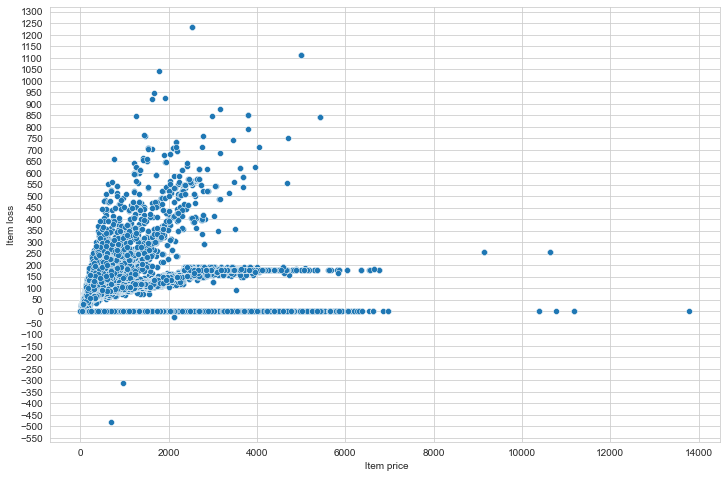

In [24]:
# Посмотрим корреляцию между item_price и таргетом
plt.figure(figsize=(12, 8))
sns.scatterplot(x='item_price', y='item_losses', data=train_df)
plt.xlabel(' Item price')
plt.ylabel('Item loss')
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(50))
plt.show()

In [25]:
# Мы видим, что item_price хорошо объясняет поведение целевой переменной, кроме случаев когда таргет принимает значения 0 и ~ 180. Зафиксируем этот и вернемся к нему позже, возможно один из категориальных признаков объяснит такое поведение таргета.

### Categorical features exploration

In [26]:
train_df[train_categorical_columns].sample(3)

,order_id,order_date,stock_departure_date,delivery_service_departure_date,client_arrival_date,client_keywords,item_package_type,brand_name,item_id,item_category,...,departure_region,arrival_country,arrival_city,arrival_region,item_type,client_device_type,client_browser,client_is_app,order_tracking_available,type_prepayment
255156,a61e1b6f-bbda-404c-9bf9-9d0bec61e0b5,2017-08-09 17:34:28,19-58-00 2017-08-23,04-20-00 2017-08-24,14-07-00 2017-08-25,None,4b30b1ff-54b0-4aac-ac8a-6df7bb59548e,[],631b2ec1-2564-4f4f-bd8b-ea4e8f129f67,25f9f297-40a8-45d9-bb67-4b0f6dad1315,...,280,12,402.0,347,1,2,3,1,1,2
57614,e50195cf-ca16-481a-b114-af130cbb5fc5,2016-11-14 21:26:45,19-47-00 2016-11-18,19-47-00 2016-11-18,21-12-00 2016-11-18,None,c82a2ea6-cbf1-46af-98c5-acd43b174f5d,"['d6031746-5020-4a5b-af39-416ba1befd5a', '9e89...",617fd321-515e-4d4e-9f63-29f75d5d7137,5554bea4-f3cd-4432-bb13-73698f52de88,...,1405,12,370.0,167,0,1,0,1,0,2
210772,07d11be6-4f59-4209-9f9b-dd4801842def,2016-11-14 12:52:04,22-50-00 2016-11-20,22-50-00 2016-11-20,10-04-00 2016-11-21,None,43c32a76-e5a3-4874-85c3-5377fa50b515,"['70f77f1d-7e52-4e98-a100-ae826dd1793e', '9e89...",dbbc9130-47e1-4cf6-a48d-d6a20ab3d2d0,ea77a36e-4b0c-4e8d-bf09-4c8398609ae1,...,1732,12,346.0,169,0,1,0,1,0,2


In [27]:
date_features = train_categorical_columns[1:5]
order_features = train_categorical_columns[6:]
print(date_features, order_features)

['order_date', 'stock_departure_date', 'delivery_service_departure_date', 'client_arrival_date'] ['item_package_type', 'brand_name', 'item_id', 'item_category', 'delivery_service_name', 'departure_country', 'departure_city', 'departure_region', 'arrival_country', 'arrival_city', 'arrival_region', 'item_type', 'client_device_type', 'client_browser', 'client_is_app', 'order_tracking_available', 'type_prepayment']


In [28]:
# Поищем зависимости между атипичным поведением таргета и категориальными переменными
train_df['typical'] = np.nan
train_df['typical'][train_df['item_losses'] == 0] = False
train_df['typical'][train_df['item_losses'] != 0] = True
columns_for_drop.append('typical')


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [29]:
train_df[order_features[0]].nunique()

5

In [30]:
distribution(train_df, order_features[0])

,item_package_type,typical,dist_in_group,dist_in_total
8,c82a2ea6-cbf1-46af-98c5-acd43b174f5d,False,0.735290,0.876296
9,c82a2ea6-cbf1-46af-98c5-acd43b174f5d,True,0.269640,0.876296
4,4b30b1ff-54b0-4aac-ac8a-6df7bb59548e,False,0.807248,0.103930
5,4b30b1ff-54b0-4aac-ac8a-6df7bb59548e,True,0.204898,0.103930
2,43c32a76-e5a3-4874-85c3-5377fa50b515,False,0.782484,0.063151
3,43c32a76-e5a3-4874-85c3-5377fa50b515,True,0.224152,0.063151
6,7b0818f4-617e-4843-a5c1-634d2c2a3c2f,False,0.768227,0.043997
7,7b0818f4-617e-4843-a5c1-634d2c2a3c2f,True,0.239887,0.043997
0,1d030b8e-b455-4e27-9d19-c68c1d7924a4,False,0.598826,0.002644
1,1d030b8e-b455-4e27-9d19-c68c1d7924a4,True,0.403131,0.002644


In [31]:
# есть незначительные отклонения в 1d030b8e-b455-4e27-9d19-c68c1d7924a4, но доля крайне мала.

In [31]:
train_df[order_features[1]].nunique()

113

In [32]:
distribution(train_df, order_features[1])

,brand_name,typical,dist_in_group,dist_in_total
221,[],True,0.270245,0.511429
220,[],False,0.742481,0.511429
211,['f4e0584f-4dd0-494a-a2e1-8e1f0197df31'],True,0.239293,0.135303
210,['f4e0584f-4dd0-494a-a2e1-8e1f0197df31'],False,0.769195,0.135303
202,['e5154844-2e6c-48ba-883b-2564eb8b8261'],False,0.718168,0.063590
...,...,...,...,...
14,"['15fa33ce-c07b-483d-b0be-5c9f99caaecb', '7eeb...",True,0.500000,0.000010
174,['caf89326-3ec5-4a8d-b179-8c47d4f969e2'],False,0.500000,0.000010
171,['c5677df9-354a-47c6-98cf-7394b8522c03'],True,1.000000,0.000005
160,['b0c30def-4db0-4086-9544-d35f76a0b299'],False,1.000000,0.000005


In [33]:
train_df[order_features[2]].nunique()

1866

In [36]:
distribution(train_df, order_features[2])

,item_id,typical,dist_in_group,dist_in_total
875,3f9b04ee-957a-4f82-85ba-23c914e1869a,True,0.222759,0.007502
874,3f9b04ee-957a-4f82-85ba-23c914e1869a,False,0.786207,0.007502
1337,6067214d-3b34-44ac-8330-f4c7aeae96c7,True,0.196958,0.006803
1336,6067214d-3b34-44ac-8330-f4c7aeae96c7,False,0.811407,0.006803
1525,6fc1477e-fd04-444c-96a1-9eb890198c69,False,0.800323,0.006400
...,...,...,...,...
1312,5dbbc6ba-d254-4b83-b0d5-e43df6501fa1,False,1.000000,0.000005
2416,b3f02078-8b4d-4311-84a3-d4d3ded29c21,False,1.000000,0.000005
3159,f0e201b6-6fb2-4ab6-b419-4b92447a218a,False,1.000000,0.000005
2401,b317948d-114f-43fc-946a-6716091b75f1,False,1.000000,0.000005


In [37]:
train_df[order_features[3]].nunique()

6

In [38]:
distribution(train_df, order_features[3])

,item_category,typical,dist_in_group,dist_in_total
10,ea77a36e-4b0c-4e8d-bf09-4c8398609ae1,False,0.738837,0.349237
11,ea77a36e-4b0c-4e8d-bf09-4c8398609ae1,True,0.273222,0.349237
6,5554bea4-f3cd-4432-bb13-73698f52de88,False,0.747983,0.327606
7,5554bea4-f3cd-4432-bb13-73698f52de88,True,0.259503,0.327606
2,25f9f297-40a8-45d9-bb67-4b0f6dad1315,False,0.762712,0.262101
3,25f9f297-40a8-45d9-bb67-4b0f6dad1315,True,0.252033,0.262101
8,60959c0c-9c1a-434b-8442-3b8c2fc73655,False,0.773536,0.051494
9,60959c0c-9c1a-434b-8442-3b8c2fc73655,True,0.237416,0.051494
0,243f0bd2-7e7b-4b32-96f9-5bd080948936,False,0.740741,0.005448
1,243f0bd2-7e7b-4b32-96f9-5bd080948936,True,0.267806,0.005448


In [39]:
train_df[order_features[4]].nunique()

25

In [40]:
distribution(train_df, order_features[4])

,delivery_service_name,typical,dist_in_group,dist_in_total
18,5c8a6701-853f-4721-86f0-86e79f7220c4,True,0.271485,0.746451
17,5c8a6701-853f-4721-86f0-86e79f7220c4,False,0.740513,0.746451
42,eec00286-b56b-44b0-8882-7b7022355a8f,True,0.239502,0.138729
41,eec00286-b56b-44b0-8882-7b7022355a8f,False,0.768852,0.138729
9,409f1e13-81ae-4e36-9bd2-6a6c53d38601,True,0.225189,0.033521
8,409f1e13-81ae-4e36-9bd2-6a6c53d38601,False,0.784689,0.033521
44,fcaa3980-7779-4590-9c18-8ce1c03b6ee9,True,0.212412,0.022676
43,fcaa3980-7779-4590-9c18-8ce1c03b6ee9,False,0.789414,0.022676
24,85282487-c17a-41ff-bedd-d0461a3e7330,True,0.230132,0.019986
23,85282487-c17a-41ff-bedd-d0461a3e7330,False,0.785141,0.019986


In [41]:
train_df[order_features[5]].nunique()

12

In [42]:
distribution(train_df, order_features[5])

,departure_country,typical,dist_in_group,dist_in_total
19,12,True,0.261871,0.980511
18,12,False,0.749315,0.980511
4,3,False,0.787091,0.010741
5,3,True,0.216763,0.010741
2,2,False,0.748201,0.002157
3,2,True,0.270983,0.002157
14,8,True,0.252404,0.002152
13,8,False,0.771635,0.002152
6,4,False,0.688442,0.002059
7,4,True,0.326633,0.002059


In [43]:
train_df[order_features[6]].nunique()

587

In [44]:
distribution(train_df, order_features[6])

,departure_city,typical,dist_in_group,dist_in_total
181,121.0,True,0.256197,0.358814
180,121.0,False,0.752988,0.358814
188,125.0,False,0.756348,0.146303
189,125.0,True,0.253448,0.146303
653,418.0,True,0.268055,0.019629
...,...,...,...,...
122,85.0,False,1.000000,0.000005
746,482.0,False,1.000000,0.000005
449,292.0,False,1.000000,0.000005
450,292.0,True,1.000000,0.000005


In [45]:
train_df[order_features[7]].nunique()

1220

In [48]:
distribution(train_df, order_features[7])

,departure_region,typical,dist_in_group,dist_in_total
969,824,False,0.756438,0.120336
970,824,True,0.253321,0.120336
2023,1732,True,0.246253,0.108747
2022,1732,False,0.762310,0.108747
405,351,False,0.754450,0.083711
...,...,...,...,...
1402,1198,False,1.000000,0.000005
172,146,False,1.000000,0.000005
1068,909,True,1.000000,0.000005
378,331,True,1.000000,0.000005


In [49]:
train_df[order_features[8]].nunique()

13

In [50]:
distribution(train_df, order_features[8])

,arrival_country,typical,dist_in_group,dist_in_total
21,12,True,0.263842,0.954321
20,12,False,0.747331,0.954321
4,3,False,0.792881,0.016861
5,3,True,0.217858,0.016861
24,14,True,0.185529,0.016732
23,14,False,0.823129,0.016732
2,2,False,0.782462,0.003068
3,2,True,0.236088,0.003068
13,8,True,0.257862,0.002468
12,8,False,0.758910,0.002468


In [51]:
train_df[order_features[9]].nunique()

671

In [52]:
distribution(train_df, order_features[9])

,arrival_city,typical,dist_in_group,dist_in_total
204,121.0,False,0.746881,0.278699
205,121.0,True,0.263180,0.278699
211,125.0,False,0.758473,0.147312
212,125.0,True,0.250623,0.147312
275,162.0,True,0.277429,0.020607
...,...,...,...,...
595,345.0,False,1.000000,0.000005
870,504.0,False,1.000000,0.000005
1119,646.0,True,1.000000,0.000005
71,46.0,False,1.000000,0.000005


In [53]:
train_df[order_features[10]].nunique()

1395

In [54]:
distribution(train_df, order_features[10])

,arrival_region,typical,dist_in_group,dist_in_total
1097,824,True,0.247068,0.121309
1096,824,False,0.761974,0.121309
2308,1732,False,0.765145,0.100608
2309,1732,True,0.244112,0.100608
468,351,False,0.745205,0.062845
...,...,...,...,...
1365,1035,True,1.000000,0.000005
1385,1048,False,1.000000,0.000005
279,210,False,1.000000,0.000005
1404,1062,False,1.000000,0.000005


In [55]:
train_df[order_features[11]].nunique()

3

In [56]:
distribution(train_df, order_features[11])

,item_type,typical,dist_in_group,dist_in_total
0,0,False,0.740328,0.979010
1,0,True,0.265004,0.979010
2,1,False,0.750867,0.071604
3,1,True,0.250361,0.071604
4,2,False,1.000000,0.024167


In [57]:
train_df[order_features[12]].nunique()

468

In [58]:
distribution(train_df, order_features[12])

,client_device_type,typical,dist_in_group,dist_in_total
4,2,False,0.756446,0.627486
5,2,True,0.254001,0.627486
2,1,False,0.740414,0.158409
3,1,True,0.272552,0.158409
0,0,False,0.733279,0.152930
...,...,...,...,...
434,539,False,1.000000,0.000005
442,564,True,1.000000,0.000005
449,571,False,1.000000,0.000005
451,574,False,1.000000,0.000005


In [59]:
train_df[order_features[13]].nunique()

8

In [60]:
distribution(train_df, order_features[13])

,client_browser,typical,dist_in_group,dist_in_total
2,1,False,0.755455,0.409041
3,1,True,0.254917,0.409041
0,0,False,0.741564,0.339288
1,0,True,0.270925,0.339288
12,6,False,0.759815,0.087240
13,6,True,0.251987,0.087240
6,3,False,0.746715,0.055907
7,3,True,0.263557,0.055907
4,2,False,0.765673,0.050009
5,2,True,0.243534,0.050009


In [61]:
train_df[order_features[14]].nunique()

2

In [62]:
distribution(train_df, order_features[14])

,client_is_app,typical,dist_in_group,dist_in_total
2,1,False,0.751054,0.962252
3,1,True,0.260167,0.962252
0,0,False,0.713816,0.037748
1,0,True,0.296053,0.037748


In [63]:
train_df[order_features[15]].nunique()

2

In [64]:
distribution(train_df, order_features[15])

,order_tracking_available,typical,dist_in_group,dist_in_total
0,0,False,0.748341,0.969356
1,0,True,0.262830,0.969356
2,1,False,0.790984,0.030644
3,1,True,0.220159,0.030644


In [65]:
train_df[order_features[16]].nunique()

4

In [66]:
distribution(train_df, order_features[16])

,type_prepayment,typical,dist_in_group,dist_in_total
4,2,False,0.752077,0.830933
5,2,True,0.259374,0.830933
2,1,False,0.730882,0.089914
3,1,True,0.279418,0.089914
0,0,False,0.745419,0.079055
1,0,True,0.263809,0.079055
6,3,False,0.789474,0.000098
7,3,True,0.210526,0.000098


In [ ]:
# Каких-то существенных взаимосвязей не выявлено

### Date features preprocessing

In [68]:
train_df[date_features[0]].min(), train_df[date_features[0]].max(), test_df[date_features[0]].min(), test_df[date_features[0]].max()

('2016-09-12 00:47:20',
 '2018-03-01 00:34:19',
 '2018-03-01 00:37:48',
 '2018-06-01 00:32:40')

In [71]:
train_df[date_features].sample(3)

,order_date,stock_departure_date,delivery_service_departure_date,client_arrival_date
214614,2017-11-30 09:02:11,10-21-00 2017-12-01,10-21-00 2017-12-01,15-43-00 2017-12-01
163000,2017-12-13 19:58:04,19-24-00 2017-12-30,19-24-00 2017-12-30,22-25-00 2017-12-30
119188,2017-10-08 19:47:08,14-38-00 2017-10-29,14-38-00 2017-10-29,08-53-00 2017-10-30


In [69]:
train_df['order_hour'] = pd.to_datetime(train_df[date_features[0]], format='%Y-%m-%d', errors='coerce').dt.hour

In [72]:
train_df[date_features[0]] = pd.to_datetime(train_df[date_features[0]], format='%Y-%m-%d', errors='coerce').dt.date
train_df[date_features[1]] = pd.to_datetime(train_df[date_features[1]], format='%H-%M-%S %Y-%m-%d', errors='coerce').dt.date
train_df[date_features[2]] = pd.to_datetime(train_df[date_features[2]], format='%H-%M-%S %Y-%m-%d', errors='coerce').dt.date
train_df[date_features[3]] = pd.to_datetime(train_df[date_features[3]], format='%H-%M-%S %Y-%m-%d', errors='coerce').dt.date

In [73]:
train_df['order_arrival_diff'] = (pd.to_datetime(train_df[date_features[3]]) - pd.to_datetime(train_df[date_features[0]])).dt.days
train_df['order_stock_diff'] = (pd.to_datetime(train_df[date_features[1]]) - pd.to_datetime(train_df[date_features[0]])).dt.days
train_df['stock_delivery_service_diff'] = (pd.to_datetime(train_df[date_features[2]]) - pd.to_datetime(train_df[date_features[1]])).dt.days
train_df['delivery_service_arrival_diff'] = (pd.to_datetime(train_df[date_features[3]]) - pd.to_datetime(train_df[date_features[2]])).dt.days

In [74]:
train_df['order_day'] = pd.to_datetime(train_df[date_features[0]]).dt.day_name()
train_df['stock_departure_day'] = pd.to_datetime(train_df[date_features[1]]).dt.day_name()
train_df['delivery_service_departure_day'] = pd.to_datetime(train_df[date_features[2]]).dt.day_name()
train_df['client_arrival_day'] = pd.to_datetime(train_df[date_features[3]]).dt.day_name()

In [75]:
columns_for_drop

['client_keywords', 'order_id', 'item_losses', 'typical']

In [76]:
columns_for_drop.append('order_date')
columns_for_drop.append('stock_departure_date')
columns_for_drop.append('delivery_service_departure_date')
columns_for_drop.append('client_arrival_date')

In [77]:
train_categorical_columns.append('order_hour')
train_categorical_columns.append('order_day')
train_categorical_columns.append('stock_departure_day')
train_categorical_columns.append('delivery_service_departure_day')
train_categorical_columns.append('client_arrival_day')

### Baseilne

In [ ]:
# Построим модель, возможно она сможет найти неочевидные закономерности

In [78]:
train_numerical_columns = [i for i in train_numerical_columns if i not in columns_for_drop]
train_categorical_columns = [i for i in train_categorical_columns if i not in columns_for_drop]

In [79]:
train_df[train_categorical_columns] = train_df[train_categorical_columns].astype(str)
train_df[train_categorical_columns] = train_df[train_categorical_columns].fillna('None')

In [80]:
target_var = 'item_losses'

In [81]:
y = train_df[target_var]
X = train_df.drop(columns_for_drop, axis=1)

In [82]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.1, random_state=42)

In [83]:
model_params = {
    'learning_rate': 1,
    'max_depth': 5,
    'iterations': 100,
    'loss_function': 'RMSE'
}

In [84]:
train_pool = Pool(X_train, y_train, cat_features=train_categorical_columns)
val_pool = Pool(X_val, y_val, cat_features=train_categorical_columns)

In [85]:
ctb_reg = CatBoostRegressor(**model_params)

In [86]:
ctb_reg.fit(train_pool, eval_set=val_pool, verbose=True)

0:	learn: 46.9541394	test: 47.1267670	best: 47.1267670 (0)	total: 361ms	remaining: 35.7s
1:	learn: 46.6936225	test: 46.8669634	best: 46.8669634 (1)	total: 464ms	remaining: 22.7s
2:	learn: 46.5651468	test: 46.7276616	best: 46.7276616 (2)	total: 596ms	remaining: 19.3s
3:	learn: 46.4645676	test: 46.6419717	best: 46.6419717 (3)	total: 726ms	remaining: 17.4s
4:	learn: 46.3364390	test: 46.4549115	best: 46.4549115 (4)	total: 818ms	remaining: 15.6s
5:	learn: 46.2553729	test: 46.3739700	best: 46.3739700 (5)	total: 913ms	remaining: 14.3s
6:	learn: 46.1910331	test: 46.3574995	best: 46.3574995 (6)	total: 998ms	remaining: 13.3s
7:	learn: 46.1638780	test: 46.3455950	best: 46.3455950 (7)	total: 1.08s	remaining: 12.4s
8:	learn: 46.1244833	test: 46.2885194	best: 46.2885194 (8)	total: 1.17s	remaining: 11.9s
9:	learn: 46.0893790	test: 46.2667943	best: 46.2667943 (9)	total: 1.27s	remaining: 11.5s
10:	learn: 46.0721432	test: 46.2478567	best: 46.2478567 (10)	total: 1.36s	remaining: 11s
11:	learn: 46.0500315

In [88]:
y_pred = ctb_reg.predict(X_val)

In [89]:
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R^2 Score: {r2}')

Mean Absolute Error (MAE): 31.53034945173836
Mean Squared Error (MSE): 2067.329544179232
Root Mean Squared Error (RMSE): 45.46789575270921
R^2 Score: 0.10010227142430739


In [90]:
# Модель показывает весьма слабую обобщающую способность, низкий показатель R^2

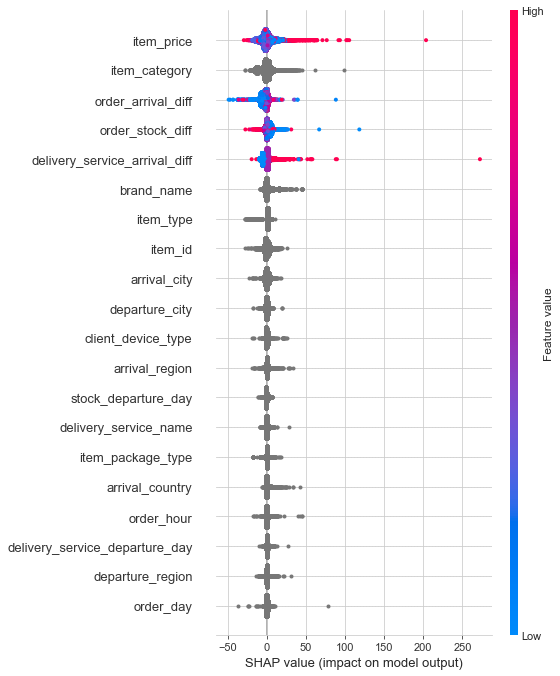

In [91]:
explainer = TreeExplainer(ctb_reg)
shap_values = explainer.shap_values(X_val, y_val)
shap.summary_plot(shap_values, X_val, X_val.columns)

In [92]:
# по item_price каша, крайне малый вклад большей части категориальных переменных.

In [93]:
residuals = y_val - y_pred

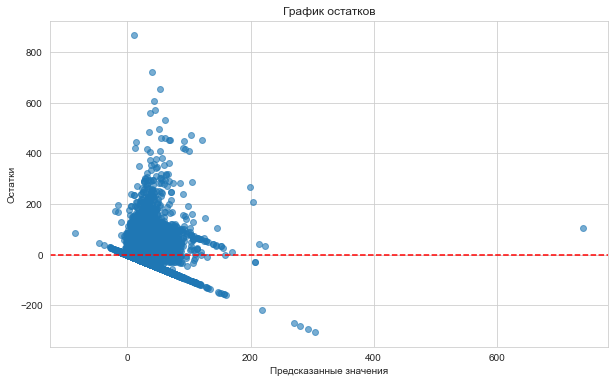

In [94]:
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.title('График остатков')
plt.show()

In [95]:
# Модель крайне плохо обобщает таргет при значении 0 и ~ 180

### Выдвинем гипотезу, что часть наблюдений - это мусор и почистим датасет

In [97]:
train_df['item_losses'].min()

-480.8484299516908

In [98]:
train_df = train_df[train_df['item_losses'] > 0]

In [99]:
train_df = train_df[train_df['item_losses'].round(6) != 180.042271]

In [101]:
train_df.shape

(75041, 35)

In [100]:
y = train_df[target_var]
X = train_df.drop(columns_for_drop, axis=1)

In [102]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.1, random_state=42)

In [103]:
train_pool = Pool(X_train, y_train, cat_features=train_categorical_columns)
val_pool = Pool(X_val, y_val, cat_features=train_categorical_columns)

In [104]:
ctb_reg.fit(train_pool, eval_set=val_pool, verbose=True)

0:	learn: 38.2480814	test: 38.2482782	best: 38.2482782 (0)	total: 22.2ms	remaining: 2.2s
1:	learn: 36.7515538	test: 36.2917075	best: 36.2917075 (1)	total: 50.9ms	remaining: 2.49s
2:	learn: 36.2759358	test: 35.8694604	best: 35.8694604 (2)	total: 72.3ms	remaining: 2.34s
3:	learn: 35.6668959	test: 34.6244661	best: 34.6244661 (3)	total: 90.5ms	remaining: 2.17s
4:	learn: 35.1666419	test: 33.7984783	best: 33.7984783 (4)	total: 115ms	remaining: 2.18s
5:	learn: 34.6634676	test: 34.0547978	best: 33.7984783 (4)	total: 143ms	remaining: 2.23s
6:	learn: 34.4329739	test: 33.8905867	best: 33.7984783 (4)	total: 161ms	remaining: 2.14s
7:	learn: 34.2782970	test: 33.6273101	best: 33.6273101 (7)	total: 178ms	remaining: 2.05s
8:	learn: 34.1482936	test: 33.4905963	best: 33.4905963 (8)	total: 199ms	remaining: 2.01s
9:	learn: 34.0142476	test: 33.6298058	best: 33.4905963 (8)	total: 217ms	remaining: 1.96s
10:	learn: 33.8327868	test: 33.5254664	best: 33.4905963 (8)	total: 234ms	remaining: 1.89s
11:	learn: 33.614

In [105]:
y_pred = ctb_reg.predict(X_val)

In [106]:
y_pred[y_pred < 0].shape

(0,)

In [107]:
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R^2 Score: {r2}')

Mean Absolute Error (MAE): 17.38923502764319
Mean Squared Error (MSE): 1566.0888372831623
Root Mean Squared Error (RMSE): 39.57384031507635
R^2 Score: 0.4904065350662079


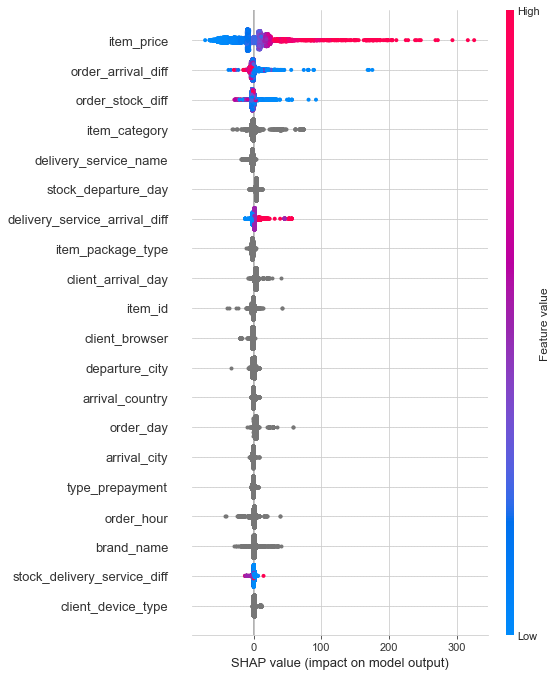

In [108]:
explainer = TreeExplainer(ctb_reg)
shap_values = explainer.shap_values(X_val, y_val)
shap.summary_plot(shap_values, X_val, X_val.columns)

In [109]:
residuals = y_val - y_pred

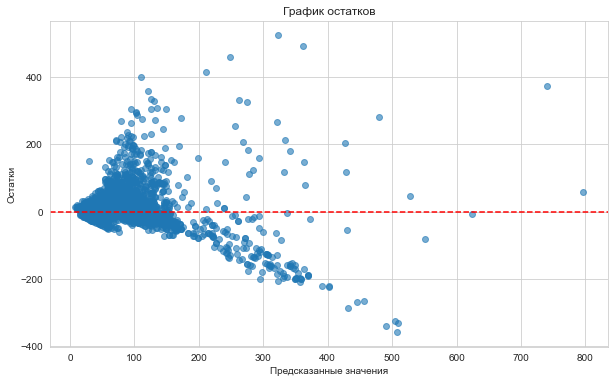

In [110]:
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.title('График остатков')
plt.show()

In [112]:
# Стало значительно лучше. Теперь сравним распределения переменных в очищенном и тестовом датасете

In [113]:
# Предварительно предобработаем датасеты в Preprocessing.ipynb

In [115]:
columns_for_drop.remove('typical')

In [118]:
np.save('./data/vars/categorical_columns.npy', train_categorical_columns)
np.save('./data/vars/date_features_columns.npy', date_features)
np.save('./data/vars/columns_for_drop.npy', columns_for_drop)